# Explorative analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
filename = './yelp_academic_dataset_review.csv'

In [4]:
yelp_review = pd.read_csv(filename)

In [4]:
yelp_review = yelp_review.dropna()
yelp_review.date = pd.to_datetime(yelp_review.date)
yelp_review['year'] = yelp_review.date.dt.year


yelp_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5996993 entries, 0 to 5996997
Data columns (total 10 columns):
business_id    object
cool           int64
date           datetime64[ns]
funny          float64
review_id      object
stars          float64
text           object
useful         float64
user_id        object
year           int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 503.3+ MB


In [10]:
top_reviewed = yelp_review[yelp_review["stars"] > 3]
top_reviewed.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,year
1,pomGBqfbxcqPv14c3XH-ZQ,0,2012-11-13,0.0,dDl8zu1vWPdKGihJrwQbpw,5.0,I love this place! My fiance And I go here atl...,0.0,msQe1u7Z_XuqjGoqhB0J5g,2012
4,Ums3gaP2qM3W1XcA5r6SsQ,0,2014-09-05,0.0,jsDu6QEJHbwP2Blom1PLCA,5.0,Delicious healthy food. The steak is amazing. ...,0.0,msQe1u7Z_XuqjGoqhB0J5g,2014
6,AxeQEz3-s9_1TyIo-G7UQw,0,2011-10-10,0.0,brokEno2n7s4vrwmmUdr9w,5.0,"If you like Thai food, you have to try the ori...",1.0,msQe1u7Z_XuqjGoqhB0J5g,2011
7,zdE82PiD6wquvjYLyhOJNA,0,2012-04-18,1.0,kUZWBVZvhWuC8TWUg5AYyA,5.0,AMAZING!!!\n\n I was referred here by a friend...,0.0,msQe1u7Z_XuqjGoqhB0J5g,2012
8,EAwh1OmG6t6p3nRaZOW_AA,0,2011-02-25,0.0,wcqt0III88LEcm19IxFFyA,4.0,Ribs = amazing\n2 hour wait time= not so amazi...,0.0,msQe1u7Z_XuqjGoqhB0J5g,2011


Text(0.5, 1.0, 'Barplot of positive and negative reviews')

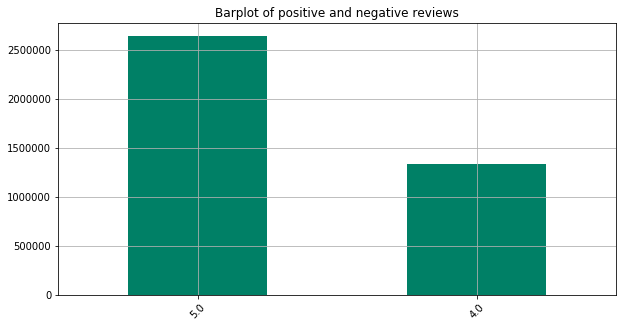

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

top_reviewed.stars.value_counts().plot(kind="bar", rot=45, figsize=(10,5), grid=True, colormap='summer')
plt.title('Barplot of positive and negative reviews')

## Average and median of reviews per place: this metric gives an insight on which are the most reviewed places

In [12]:
top_reviewed = yelp_review[yelp_review["stars"] >= 0]

top_reviews_dict = {}

for business_id in top_reviewed["business_id"].values:
    try :
        top_reviews_dict[business_id] = top_reviews_dict[business_id] + 1
    except:
        top_reviews_dict[business_id] = 1
        
topbusiness = pd.DataFrame.from_dict(data= top_reviews_dict,orient="index")


topbusiness.reset_index(inplace=True)
topbusiness.columns = ['business_id', 'rated']
del(top_reviews_dict)

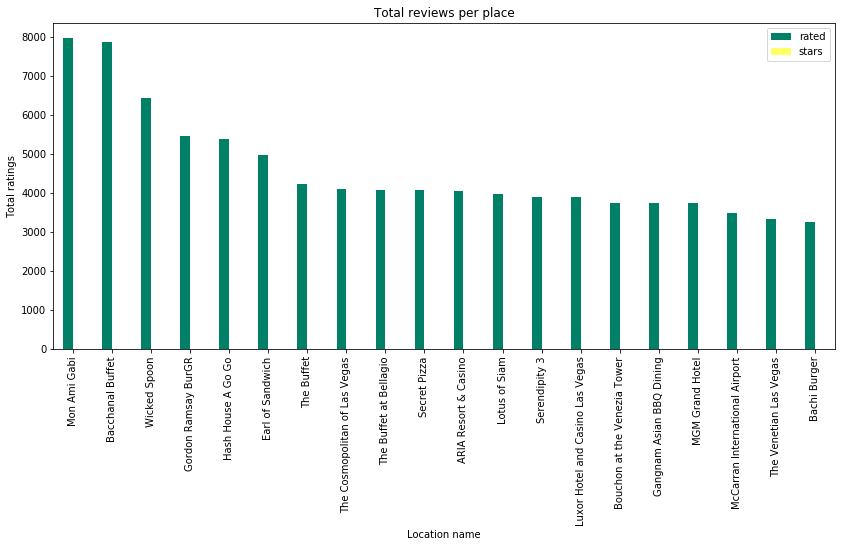

In [13]:
yelp_business = pd.read_csv('yelp_academic_dataset_business.csv')

top_count = 20
right=pd.DataFrame(yelp_business[['business_id',"name","categories", 'stars']].values, # remove stars for old plot
                    columns=['business_id',"Location name","categories",'stars'])

top_business_data = pd.merge(topbusiness,right=right, how= "inner",on='business_id')
top_business_data.sort_values("rated")[::-1][ : top_count].plot(x = "Location name", 
                                                   kind= "bar", figsize=(14,6),
                                                   title= 'Total reviews per place', colormap='summer').set_ylabel("Total ratings")

del(topbusiness)
del(right)

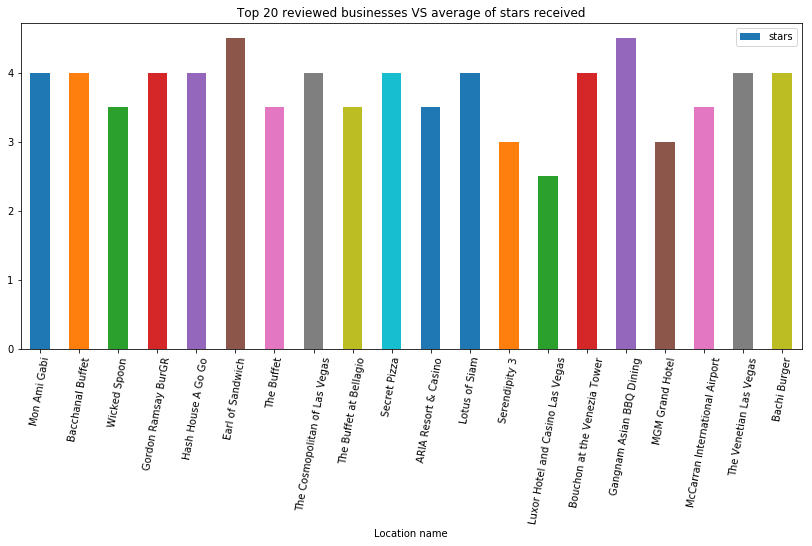

In [14]:
top_business_data.sort_values("rated")[::-1][ : top_count].plot(kind='bar', 
                                                                x='Location name', 
                                                                y='stars', 
                                                                rot=80,
                                                               figsize=(14,6),
                                                               title='Top 20 reviewed businesses VS average of stars received')

In [15]:
top_business_data.stars = top_business_data.stars.astype('int64')
top_business_data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,rated,stars
rated,1,0.026
stars,0.026,1


No correlation between number of reviews and average number of stars received

## Frequency of reviews by date and time series decomposition for positive reviewed locations

In [16]:
top_reviewed['y'] = 1
results = top_reviewed.groupby(['date']).count()
#results = results[['y']]

In [17]:
idx = pd.date_range(results.index.min(), results.index.max())

results.index = pd.DatetimeIndex(results.index)
results = results.reindex(idx, fill_value=0)


results['ds'] = results.index

In [18]:
from fbprophet import Prophet

m = Prophet()
m.fit(results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
future = m.make_future_dataframe(periods=0)

In [20]:
forecast = m.predict(future)

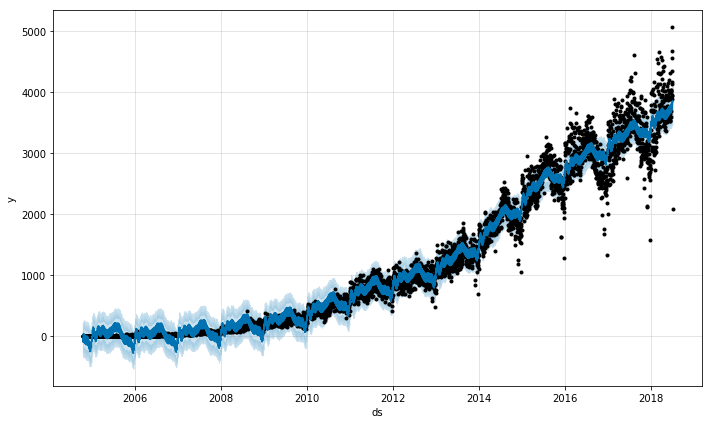

In [21]:
fig1 = m.plot(forecast)

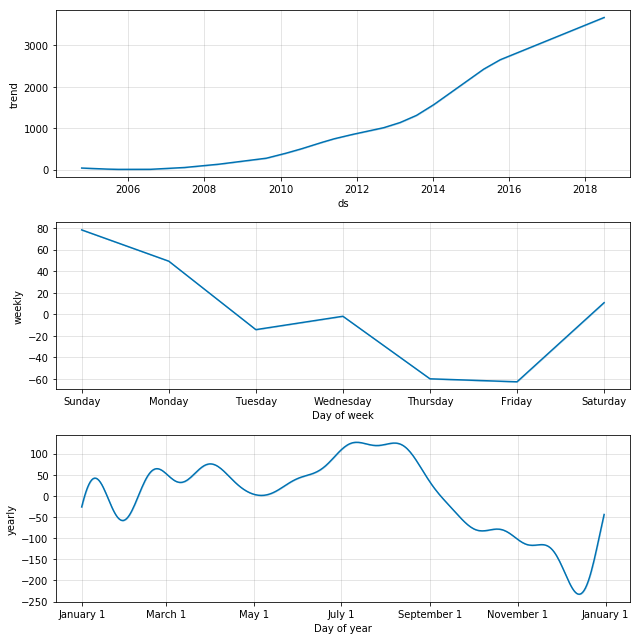

In [22]:
fig2 = m.plot_components(forecast)

## Most reviewed businesses

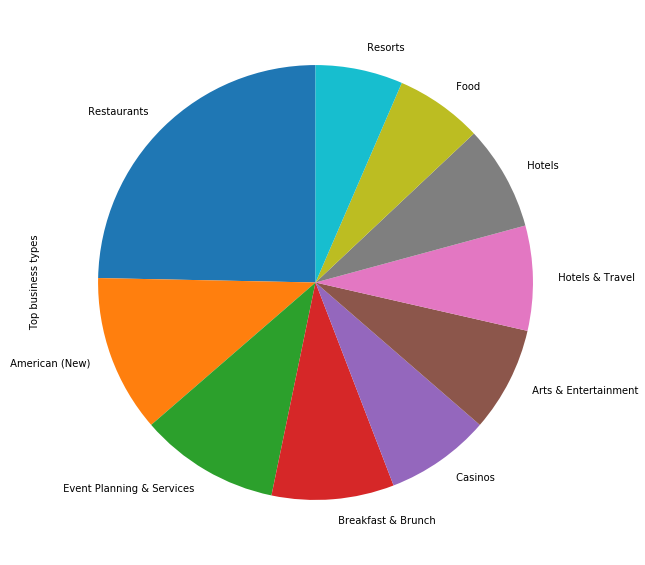

In [23]:
num_cat =10 # to show top 10 catrgories
top_business = 30 # choose categories of top 30 businesses
cat_data = top_business_data.sort_values("rated")[::-1][:top_business]
#cat_data.categories
Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(",")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
top_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
top_categories.reset_index(inplace=True)
top_categories.columns = ['category', 'occurance']

x_val=top_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=top_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Top business types')
series.plot.pie(figsize=(10, 10),startangle=90)

## Negatively reviwed businesses

In [24]:
bottom_reviewed = yelp_review[yelp_review["stars"] < 3]
bottom_reviews_dict ={} 

for business_id in bottom_reviewed["business_id"].values:
    try :
        bottom_reviews_dict[business_id] =bottom_reviews_dict[business_id]+1
    except:
        bottom_reviews_dict[business_id]=1
        
bottombusiness = pd.DataFrame.from_dict(data= bottom_reviews_dict,orient="index")

bottombusiness.reset_index(inplace=True)
#bottombusiness.head()
bottombusiness.columns = ['business_id', 'rated']

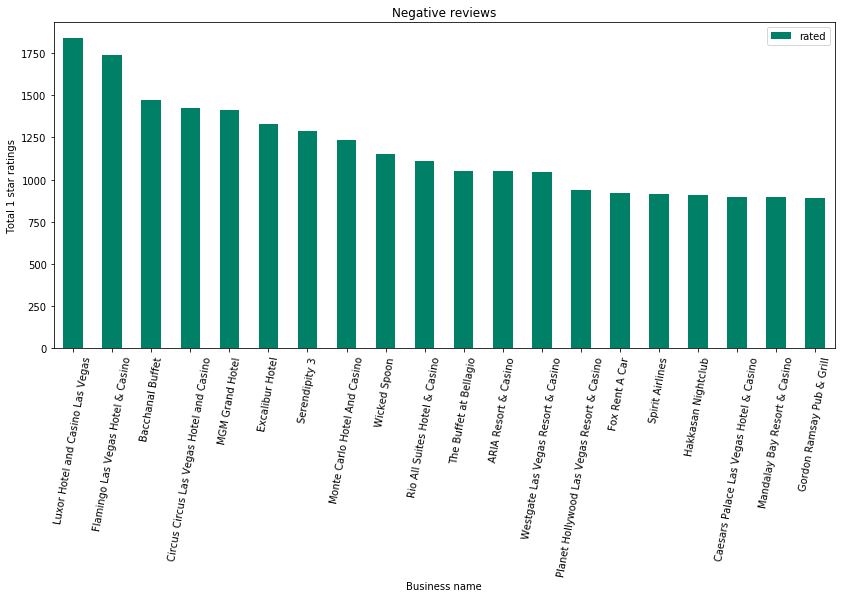

In [25]:
top_count= 20
right=pd.DataFrame(yelp_business[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

bottom_business_data = pd.merge(bottombusiness,right=right, how="inner",on='business_id')
bottom_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Negative reviews', 
                                                                 rot=80,
                                                                colormap='summer').set_ylabel("Total 1 star ratings")

del(bottom_reviewed)
del(bottom_reviews_dict)
del(bottombusiness)
del(right)

## Most common words in positive and negative reviews

In [6]:
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import collections

def tokenize(s):
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    return filtered_words


def count_ngrams(lines, min_length= 2, max_length= 4):
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams

def print_word_cloud(ngrams, num=10):
    words = []
    for n in sorted(ngrams):
        for gram, count in ngrams[n].most_common(num):
            s = ' '.join(gram)
            words.append(s)
            
    cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate(' '.join(words))
    plt.figure(figsize=(20, 15))
    plt.imshow(cloud)
    plt.axis('off');
    plt.show()
    print('')

In [19]:
n_grams = count_ngrams(yelp_review['text'].values[0:1000])

KeyboardInterrupt: 

### Negative reviews wordcloud

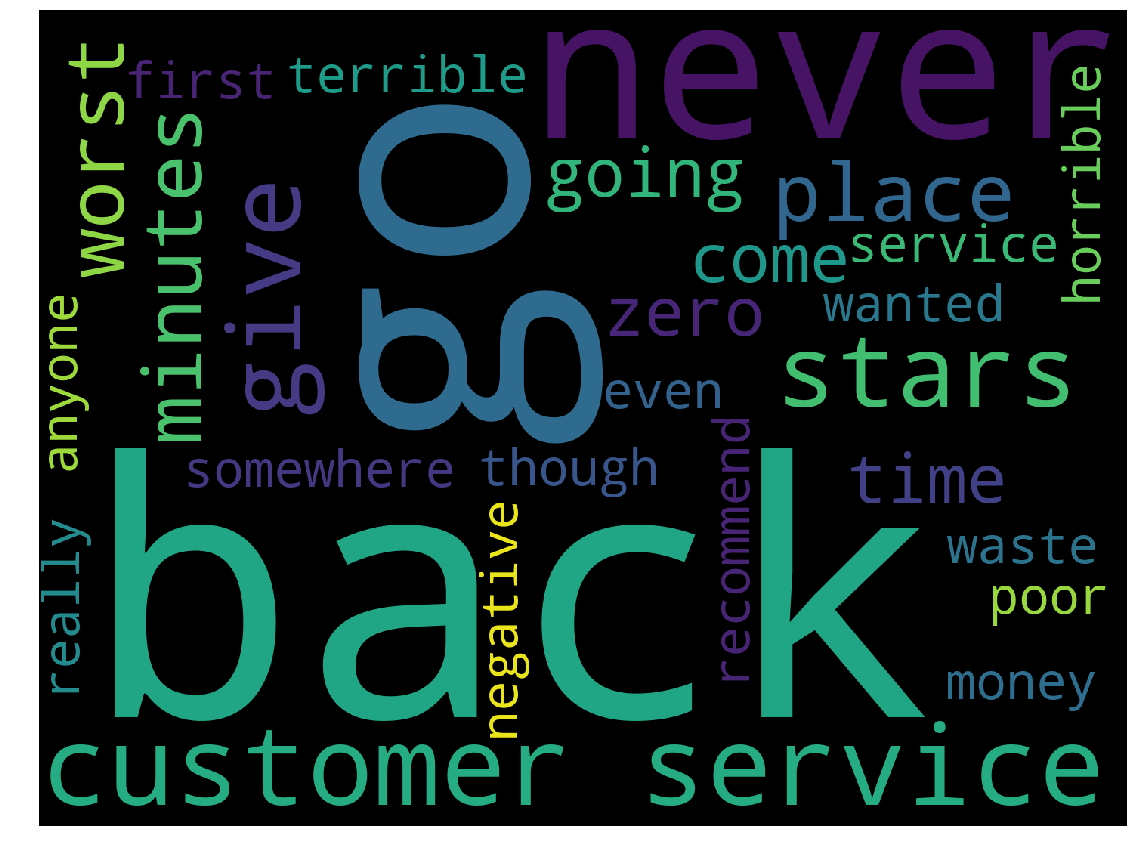

In [7]:
negative = yelp_review[yelp_review['stars'] < 3][0:200000]
negative_n_grams = count_ngrams(negative['text'])
print_word_cloud(negative_n_grams)

### Positive reviews wordcloud

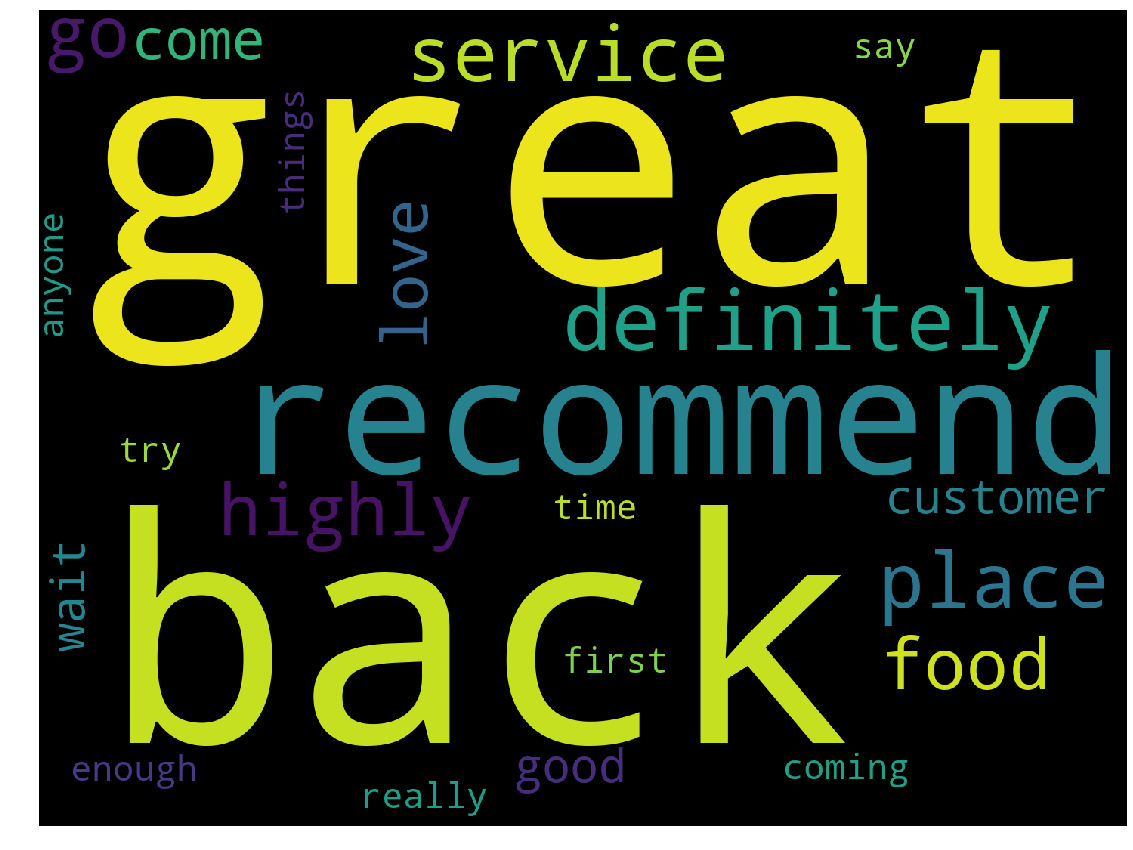

In [8]:
positive = yelp_review[yelp_review['stars'] >=3][0:200000]
positive_n_grams = count_ngrams(positive['text'])
print_word_cloud(positive_n_grams)